## JWST F770W Mosaic 2 Tile Simulation Data Reduction

M101 as the target.  Using IRAC 8 micron scaled to look like it was observed with JWST (pixel size scaled by 0.8/6.5)

Based on excellent JWebbinar image data reduction notebooks authored by B. Hilbert

In [1]:
# Packages that allow us to get information about objects:
import asdf
import copy
import os
import shutil
import glob

# Numpy library:
import numpy as np

# For downloading data
import requests

# Astropy tools:
from astropy.io import ascii, fits
from astropy.utils.data import download_file
from astropy.visualization import ImageNormalize, ManualInterval, LogStretch
from astropy.visualization import simple_norm

In [2]:
import astropy
print(astropy.__version__)

5.0


In [3]:
os.environ["CRDS_PATH"] = "/home/kgordon/crds_cache"
os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import ImageGrid

# Use this version for non-interactive plots (easier scrolling of the notebook)
%matplotlib inline

# Use this version (outside of Jupyter Lab) if you want interactive plots
#%matplotlib notebook

# These gymnastics are needed to make the sizes of the figures
# be the same in both the inline and notebook versions
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

In [5]:
# List of possible data quality flags
from jwst.datamodels import dqflags

# entire pipelines pipeline
from jwst.pipeline import calwebb_detector1
from jwst.pipeline import calwebb_image2
from jwst.pipeline import calwebb_image3

# Individual steps that make up calwebb_detector1
from jwst.dq_init import DQInitStep
from jwst.saturation import SaturationStep
from jwst.superbias import SuperBiasStep
from jwst.ipc import IPCStep                                                                                    
from jwst.refpix import RefPixStep                                                                
from jwst.linearity import LinearityStep
from jwst.persistence import PersistenceStep
from jwst.dark_current import DarkCurrentStep
from jwst.jump import JumpStep
from jwst.ramp_fitting import RampFitStep
from jwst import datamodels

from jwst.associations import asn_from_list
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base

In [6]:
import jwst
print(jwst.__version__)

1.4.3


In [7]:
def show_image(data_2d, vmin, vmax, xpixel=None, ypixel=None, title=None):
    """Function to generate a 2D, log-scaled image of the data, 
    with an option to highlight a specific pixel (with a red dot).
    
    Parameters
    ----------
    data_2d : numpy.ndarray
        Image to be displayed
        
    vmin : float
        Minimum signal value to use for scaling
        
    vmax : float
        Maximum signal value to use for scaling
        
    xpixel : int
        X-coordinate of pixel to highlight
        
    ypixel : int
        Y-coordinate of pixel to highlight
        
    title : str
        String to use for the plot title
    """
    norm = ImageNormalize(data_2d, interval=ManualInterval(vmin=vmin, vmax=vmax),
                          stretch=LogStretch())
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    im = ax.imshow(data_2d, origin='lower', norm=norm)
    
    if xpixel and ypixel:
        plt.plot(xpixel, ypixel, marker='o', color='red', label='Selected Pixel')

    fig.colorbar(im, label='DN')
    plt.xlabel('Pixel column')
    plt.ylabel('Pixel row')
    if title:
        plt.title(title)

In [8]:
def overlay_catalog(data_2d, catalog, flux_limit=0, vmin=0, vmax=10,
                    title=None, units='MJy/str'):
    """Function to generate a 2D image of the data, 
    with sources overlaid.
    
    data_2d : numpy.ndarray
        2D image to be displayed
        
    catalog : astropy.table.Table
        Table of sources
    
    flux_limit : float
        Minimum signal threshold to overplot sources from catalog.
        Sources below this limit will not be shown on the image.
        
    vmin : float
        Minimum signal value to use for scaling
        
    vmax : float
        Maximum signal value to use for scaling
        
    title : str
        String to use for the plot title
                
    units : str
        Units of the data. Used for the annotation in the
        color bar
    """
    norm = ImageNormalize(data_2d, interval=ManualInterval(vmin=vmin, vmax=vmax),
                              stretch=LogStretch())
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    im = ax.imshow(data_2d, origin='lower', norm=norm)
    
    for row in catalog:
        if row['aper_total_flux'].value > flux_limit:
            plt.plot(row['xcentroid'], row['ycentroid'], marker='o',
                     markersize='3', color='red')

    plt.xlabel('Pixel column')
    plt.ylabel('Pixel row')
    
    fig.colorbar(im, label=units)
    fig.tight_layout()
    plt.subplots_adjust(left=0.15)
    
    if title:
        plt.title(title)

## Overall

In [9]:
filter = "F770W"

## CALWEBB_DETECTOR1

In [10]:
miri_uncal_files = glob.glob(f"./stage0/*{filter}exp1.fits")
output_dir = './stage1'
print(miri_uncal_files)

['./stage0/det_image_seq1_MIRIMAGE_F770Wexp1.fits', './stage0/det_image_seq2_MIRIMAGE_F770Wexp1.fits', './stage0/det_image_seq3_MIRIMAGE_F770Wexp1.fits', './stage0/det_image_seq4_MIRIMAGE_F770Wexp1.fits', './stage0/det_image_seq5_MIRIMAGE_F770Wexp1.fits', './stage0/det_image_seq6_MIRIMAGE_F770Wexp1.fits', './stage0/det_image_seq7_MIRIMAGE_F770Wexp1.fits', './stage0/det_image_seq8_MIRIMAGE_F770Wexp1.fits']


In [11]:
for miri_uncal_file in miri_uncal_files:
    print(miri_uncal_file)

    # Using the run() method:
    # Instantiate the pipeline
    miri1 = calwebb_detector1.Detector1Pipeline()

    # Save the final output of the pipeline
    miri1.output_dir = output_dir
    miri1.save_results = True

    # Save the output from the jump detecion step,
    # and let's use a more stringent limit for cosmic ray
    # detection
    miri1.jump.save_results = True
    miri1.jump.rejection_threshold = 3

    # The dark current file used to create the simulated data
    # is much different and cleaner than that used in the pipeline,
    # so let's turn off the dark subtraction step in order to end up
    # with a cleaner rate image.
    miri1.dark_current.skip = True

    # Call the run() method
    miri_output = miri1.run(miri_uncal_file)


./stage0/det_image_seq1_MIRIMAGE_F770Wexp1.fits


2022-03-10 15:28:15,201 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2022-03-10 15:28:15,205 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2022-03-10 15:28:15,210 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2022-03-10 15:28:15,215 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2022-03-10 15:28:15,220 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2022-03-10 15:28:15,223 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2022-03-10 15:28:15,226 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2022-03-10 15:28:15,230 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2022-03-10 15:28:15,235 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2022-03-10 15:28:15,239 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2022-03-10 1

2022-03-10 15:28:18,394 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2022-03-10 15:28:18,396 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_reset_0047.fits'.
2022-03-10 15:28:18,398 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_rscd_0010.fits'.
2022-03-10 15:28:18,399 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_saturation_0026.fits'.
2022-03-10 15:28:18,401 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2022-03-10 15:28:18,403 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2022-03-10 15:28:18,405 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2022-03-10 15:28:18,408 - stpipe.Detector1Pipe

2022-03-10 15:28:22,427 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2022-03-10 15:28:22,550 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 5, 1024, 1032) from det_image_seq1_MIRIMAGE_F770Wexp1.fits>,).
2022-03-10 15:28:22,553 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './stage1', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': './stage0', 'dark_output': None}
2022-03-10 15:28:22,555 - stpipe.Detector1Pipeline.dark_current - INFO - Step skipped.
2022-03-10 15:28:22,564 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2022-03-10 15:28:22,683 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 5, 1024, 1032) from det_image_seq1_MIRIMAGE_F

2022-03-10 15:28:28,665 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


./stage0/det_image_seq2_MIRIMAGE_F770Wexp1.fits


2022-03-10 15:28:28,688 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2022-03-10 15:28:28,692 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2022-03-10 15:28:28,696 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2022-03-10 15:28:28,700 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2022-03-10 15:28:28,704 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2022-03-10 15:28:28,708 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2022-03-10 15:28:28,713 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2022-03-10 15:28:28,717 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2022-03-10 15:28:28,721 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2022-03-10 15:28:28,725 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2022-03-10 1

2022-03-10 15:28:29,043 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2022-03-10 15:28:29,044 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_reset_0047.fits'.
2022-03-10 15:28:29,046 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_rscd_0010.fits'.
2022-03-10 15:28:29,048 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_saturation_0026.fits'.
2022-03-10 15:28:29,049 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2022-03-10 15:28:29,050 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2022-03-10 15:28:29,052 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2022-03-10 15:28:29,054 - stpipe.Detector1Pipe

2022-03-10 15:28:33,027 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2022-03-10 15:28:33,148 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 5, 1024, 1032) from det_image_seq2_MIRIMAGE_F770Wexp1.fits>,).
2022-03-10 15:28:33,152 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './stage1', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': './stage0', 'dark_output': None}
2022-03-10 15:28:33,154 - stpipe.Detector1Pipeline.dark_current - INFO - Step skipped.
2022-03-10 15:28:33,162 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2022-03-10 15:28:33,291 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 5, 1024, 1032) from det_image_seq2_MIRIMAGE_F

2022-03-10 15:28:39,347 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


./stage0/det_image_seq3_MIRIMAGE_F770Wexp1.fits


2022-03-10 15:28:39,372 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2022-03-10 15:28:39,376 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2022-03-10 15:28:39,379 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2022-03-10 15:28:39,383 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2022-03-10 15:28:39,386 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2022-03-10 15:28:39,390 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2022-03-10 15:28:39,395 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2022-03-10 15:28:39,398 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2022-03-10 15:28:39,402 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2022-03-10 15:28:39,405 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2022-03-10 1

2022-03-10 15:28:39,735 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2022-03-10 15:28:39,737 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_reset_0047.fits'.
2022-03-10 15:28:39,738 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_rscd_0010.fits'.
2022-03-10 15:28:39,739 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_saturation_0026.fits'.
2022-03-10 15:28:39,740 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2022-03-10 15:28:39,741 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2022-03-10 15:28:39,743 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2022-03-10 15:28:39,745 - stpipe.Detector1Pipe

2022-03-10 15:28:43,694 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2022-03-10 15:28:43,823 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 5, 1024, 1032) from det_image_seq3_MIRIMAGE_F770Wexp1.fits>,).
2022-03-10 15:28:43,828 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './stage1', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': './stage0', 'dark_output': None}
2022-03-10 15:28:43,833 - stpipe.Detector1Pipeline.dark_current - INFO - Step skipped.
2022-03-10 15:28:43,840 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2022-03-10 15:28:43,956 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 5, 1024, 1032) from det_image_seq3_MIRIMAGE_F

2022-03-10 15:28:49,680 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


./stage0/det_image_seq4_MIRIMAGE_F770Wexp1.fits


2022-03-10 15:28:49,705 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2022-03-10 15:28:49,709 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2022-03-10 15:28:49,713 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2022-03-10 15:28:49,718 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2022-03-10 15:28:49,722 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2022-03-10 15:28:49,726 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2022-03-10 15:28:49,729 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2022-03-10 15:28:49,733 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2022-03-10 15:28:49,738 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2022-03-10 15:28:49,741 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2022-03-10 1

2022-03-10 15:28:50,072 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2022-03-10 15:28:50,074 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_reset_0047.fits'.
2022-03-10 15:28:50,075 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_rscd_0010.fits'.
2022-03-10 15:28:50,077 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_saturation_0026.fits'.
2022-03-10 15:28:50,079 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2022-03-10 15:28:50,080 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2022-03-10 15:28:50,082 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2022-03-10 15:28:50,083 - stpipe.Detector1Pipe

2022-03-10 15:28:54,082 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2022-03-10 15:28:54,209 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 5, 1024, 1032) from det_image_seq4_MIRIMAGE_F770Wexp1.fits>,).
2022-03-10 15:28:54,216 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './stage1', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': './stage0', 'dark_output': None}
2022-03-10 15:28:54,219 - stpipe.Detector1Pipeline.dark_current - INFO - Step skipped.
2022-03-10 15:28:54,225 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2022-03-10 15:28:54,345 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 5, 1024, 1032) from det_image_seq4_MIRIMAGE_F

2022-03-10 15:29:00,316 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


./stage0/det_image_seq5_MIRIMAGE_F770Wexp1.fits


2022-03-10 15:29:00,342 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2022-03-10 15:29:00,346 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2022-03-10 15:29:00,350 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2022-03-10 15:29:00,354 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2022-03-10 15:29:00,360 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2022-03-10 15:29:00,363 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2022-03-10 15:29:00,368 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2022-03-10 15:29:00,372 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2022-03-10 15:29:00,375 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2022-03-10 15:29:00,378 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2022-03-10 1

2022-03-10 15:29:00,702 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2022-03-10 15:29:00,704 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_reset_0047.fits'.
2022-03-10 15:29:00,706 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_rscd_0010.fits'.
2022-03-10 15:29:00,708 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_saturation_0026.fits'.
2022-03-10 15:29:00,710 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2022-03-10 15:29:00,711 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2022-03-10 15:29:00,713 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2022-03-10 15:29:00,714 - stpipe.Detector1Pipe

2022-03-10 15:29:04,687 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2022-03-10 15:29:04,808 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 5, 1024, 1032) from det_image_seq5_MIRIMAGE_F770Wexp1.fits>,).
2022-03-10 15:29:04,812 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './stage1', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': './stage0', 'dark_output': None}
2022-03-10 15:29:04,814 - stpipe.Detector1Pipeline.dark_current - INFO - Step skipped.
2022-03-10 15:29:04,820 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2022-03-10 15:29:04,944 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 5, 1024, 1032) from det_image_seq5_MIRIMAGE_F

2022-03-10 15:29:11,116 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


./stage0/det_image_seq6_MIRIMAGE_F770Wexp1.fits


2022-03-10 15:29:11,142 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2022-03-10 15:29:11,146 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2022-03-10 15:29:11,150 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2022-03-10 15:29:11,154 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2022-03-10 15:29:11,158 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2022-03-10 15:29:11,162 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2022-03-10 15:29:11,166 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2022-03-10 15:29:11,170 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2022-03-10 15:29:11,173 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2022-03-10 15:29:11,176 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2022-03-10 1

2022-03-10 15:29:11,517 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2022-03-10 15:29:11,519 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_reset_0047.fits'.
2022-03-10 15:29:11,521 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_rscd_0010.fits'.
2022-03-10 15:29:11,524 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_saturation_0026.fits'.
2022-03-10 15:29:11,526 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2022-03-10 15:29:11,528 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2022-03-10 15:29:11,529 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2022-03-10 15:29:11,531 - stpipe.Detector1Pipe

2022-03-10 15:29:15,620 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2022-03-10 15:29:15,742 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 5, 1024, 1032) from det_image_seq6_MIRIMAGE_F770Wexp1.fits>,).
2022-03-10 15:29:15,747 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './stage1', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': './stage0', 'dark_output': None}
2022-03-10 15:29:15,749 - stpipe.Detector1Pipeline.dark_current - INFO - Step skipped.
2022-03-10 15:29:15,757 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2022-03-10 15:29:15,881 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 5, 1024, 1032) from det_image_seq6_MIRIMAGE_F

2022-03-10 15:29:22,069 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


./stage0/det_image_seq7_MIRIMAGE_F770Wexp1.fits


2022-03-10 15:29:22,094 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2022-03-10 15:29:22,099 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2022-03-10 15:29:22,102 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2022-03-10 15:29:22,105 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2022-03-10 15:29:22,108 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2022-03-10 15:29:22,111 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2022-03-10 15:29:22,114 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2022-03-10 15:29:22,118 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2022-03-10 15:29:22,122 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2022-03-10 15:29:22,127 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2022-03-10 1

2022-03-10 15:29:22,450 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2022-03-10 15:29:22,452 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_reset_0047.fits'.
2022-03-10 15:29:22,454 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_rscd_0010.fits'.
2022-03-10 15:29:22,456 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_saturation_0026.fits'.
2022-03-10 15:29:22,458 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2022-03-10 15:29:22,460 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2022-03-10 15:29:22,461 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2022-03-10 15:29:22,463 - stpipe.Detector1Pipe

2022-03-10 15:29:26,408 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2022-03-10 15:29:26,526 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 5, 1024, 1032) from det_image_seq7_MIRIMAGE_F770Wexp1.fits>,).
2022-03-10 15:29:26,531 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './stage1', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': './stage0', 'dark_output': None}
2022-03-10 15:29:26,533 - stpipe.Detector1Pipeline.dark_current - INFO - Step skipped.
2022-03-10 15:29:26,540 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2022-03-10 15:29:26,665 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 5, 1024, 1032) from det_image_seq7_MIRIMAGE_F

2022-03-10 15:29:32,538 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


./stage0/det_image_seq8_MIRIMAGE_F770Wexp1.fits


2022-03-10 15:29:32,562 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2022-03-10 15:29:32,567 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2022-03-10 15:29:32,571 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2022-03-10 15:29:32,575 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2022-03-10 15:29:32,578 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2022-03-10 15:29:32,581 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2022-03-10 15:29:32,587 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2022-03-10 15:29:32,592 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2022-03-10 15:29:32,595 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2022-03-10 15:29:32,599 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2022-03-10 1

2022-03-10 15:29:32,919 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2022-03-10 15:29:32,921 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_reset_0047.fits'.
2022-03-10 15:29:32,923 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_rscd_0010.fits'.
2022-03-10 15:29:32,925 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_saturation_0026.fits'.
2022-03-10 15:29:32,927 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2022-03-10 15:29:32,929 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2022-03-10 15:29:32,930 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2022-03-10 15:29:32,932 - stpipe.Detector1Pipe

2022-03-10 15:29:36,892 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2022-03-10 15:29:37,013 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 5, 1024, 1032) from det_image_seq8_MIRIMAGE_F770Wexp1.fits>,).
2022-03-10 15:29:37,016 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './stage1', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': './stage0', 'dark_output': None}
2022-03-10 15:29:37,018 - stpipe.Detector1Pipeline.dark_current - INFO - Step skipped.
2022-03-10 15:29:37,027 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2022-03-10 15:29:37,150 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 5, 1024, 1032) from det_image_seq8_MIRIMAGE_F

2022-03-10 15:29:43,007 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


In [12]:
# look at one of the images
miri_rate_files = glob.glob(f"./stage1/*{filter}exp1_rate.fits")
miri_rate = datamodels.open(miri_rate_files[0])

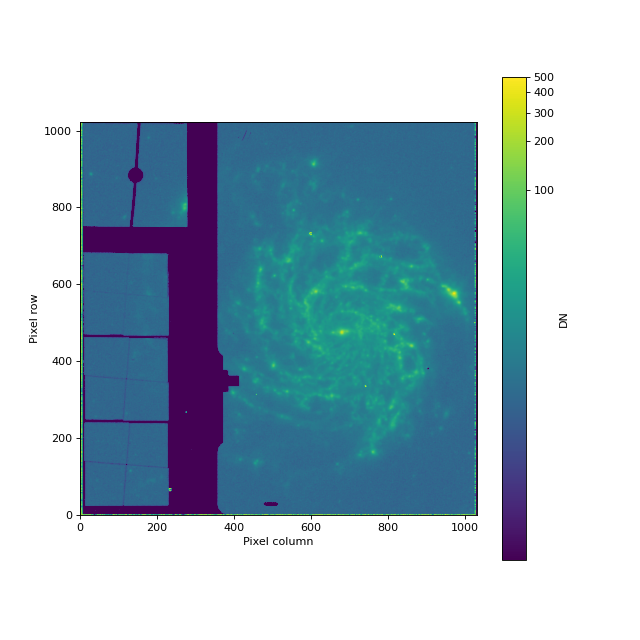

In [13]:
show_image(miri_rate.data, 2, 500)

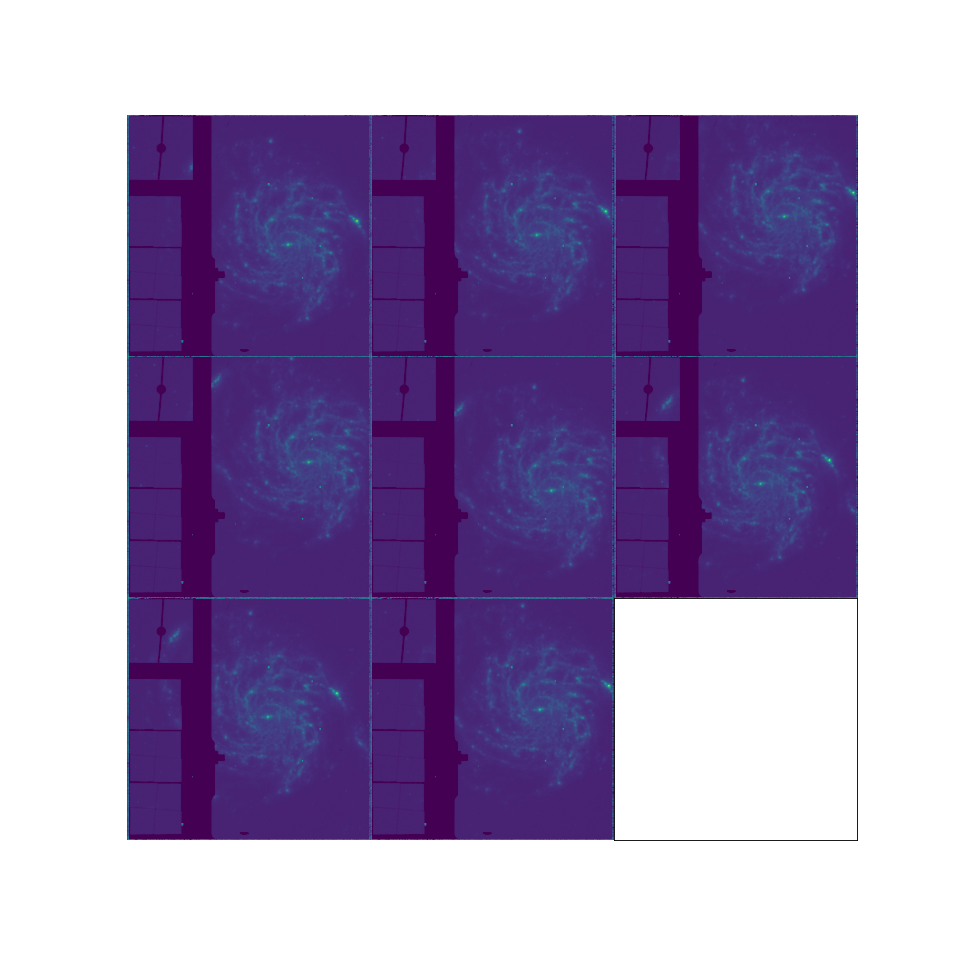

In [14]:
# display the images
fig = plt.figure(1, figsize=(12, 12))
ncols = len(miri_rate_files) // 3
grid = ImageGrid(fig, 111, nrows_ncols=(ncols+1, 3), axes_pad=0)

for i, cfile in enumerate(miri_rate_files):
    with datamodels.open(cfile) as miri_rate:
        cimage = miri_rate.data
        norm_data = simple_norm(cimage, "sqrt", min_cut=2, max_cut=500)
        grid[i].imshow(cimage, norm=norm_data, origin="lower")
        grid[i].axis('off')
        grid[i].set_xticks([])
        grid[i].set_yticks([])

## CALWEBB_IMAGE2

In [15]:
miri_rate_files = glob.glob(f"./stage1/*{filter}exp1_rate.fits")
output_dir = './stage2'
print(miri_rate_files)

['./stage1/det_image_seq1_MIRIMAGE_F770Wexp1_rate.fits', './stage1/det_image_seq2_MIRIMAGE_F770Wexp1_rate.fits', './stage1/det_image_seq3_MIRIMAGE_F770Wexp1_rate.fits', './stage1/det_image_seq4_MIRIMAGE_F770Wexp1_rate.fits', './stage1/det_image_seq5_MIRIMAGE_F770Wexp1_rate.fits', './stage1/det_image_seq6_MIRIMAGE_F770Wexp1_rate.fits', './stage1/det_image_seq7_MIRIMAGE_F770Wexp1_rate.fits', './stage1/det_image_seq8_MIRIMAGE_F770Wexp1_rate.fits']


In [16]:
miri_asn_name = f'miri_{filter}_asn'
miri_asn = asn_from_list.asn_from_list(miri_rate_files, rule=DMSLevel2bBase, product_name=miri_asn_name)

miri_asn_file = f'{miri_asn_name}.json'
with open(miri_asn_file, 'w') as outfile:
    name, serialized = miri_asn.dump(format='json')
    outfile.write(serialized)

In [17]:
# Using the run() method
# Create an instance of the pipeline class
miri_im2 = calwebb_image2.Image2Pipeline()

# Save the pipeline output, and specify the output directory
miri_im2.output_dir = output_dir
miri_im2.save_results = True

# Set any step-related paramters
miri_im2.resample.pixfrac = 1.0

# Call the run() method and provide the MIRI association file as input
miri_im2.run(miri_asn_file)

2022-03-10 15:29:46,363 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.
2022-03-10 15:29:46,368 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2022-03-10 15:29:46,374 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2022-03-10 15:29:46,380 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2022-03-10 15:29:46,385 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.
2022-03-10 15:29:46,390 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.
2022-03-10 15:29:46,537 - stpipe - WARNING - /home/kgordon/Bin/miniconda3/envs/mirisim/lib/python3.9/site-packages/stpipe/step.py:379: ResourceWarning: unclosed file <_io.FileIO name='./stage1/det_image_seq1_MIRIMAGE_F770Wexp1_rate.fits' mode='rb' closefd=True>
  gc.collect()

2022-03-10 15:29:46,554 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('miri_F770W_asn.json',).
2022-03-10 15:29:4

2022-03-10 15:29:47,773 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.019410454 -0.016139226 0.021877929 0.015048364 359.990819065 0.017621109 359.988011818 -0.013580304
2022-03-10 15:29:47,775 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2022-03-10 15:29:47,872 - stpipe.Image2Pipeline.assign_wcs - WARNING - /home/kgordon/Bin/miniconda3/envs/mirisim/lib/python3.9/site-packages/astropy/modeling/fitting.py:777: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",

2022-03-10 15:29:48,078 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done
2022-03-10 15:29:48,222 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from det_image_seq1_MIRIMAGE_F770Wexp1_rate.fits>,).
2022-03-10 15:29:48,227 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'outpu

2022-03-10 15:29:57,901 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from det_image_seq2_MIRIMAGE_F770Wexp1_rate.fits>,).
2022-03-10 15:29:57,905 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'flat_field', 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}
2022-03-10 15:29:58,161 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored
2022-03-10 15:29:58,163 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2022-03-10 15:29:58,165 - stpipe.Image2Pipeline.flat_field 

2022-03-10 15:30:07,334 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored
2022-03-10 15:30:07,336 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2022-03-10 15:30:07,337 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored
2022-03-10 15:30:07,355 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored
2022-03-10 15:30:07,630 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done
2022-03-10 15:30:07,772 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from det_image_seq3_MIRIMAGE_F770Wexp1_rate.fits>,).
2022-03-10 15:30:07,776 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are:

2022-03-10 15:30:17,094 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done
2022-03-10 15:30:17,241 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from det_image_seq4_MIRIMAGE_F770Wexp1_rate.fits>,).
2022-03-10 15:30:17,246 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'photom', 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}
2022-03-10 15:30:17,315 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /home/kgordon/crds_cache/references/jwst/miri/jwst_miri_photom_0073.fits
2022-03-10 15:30:17,317 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /home/kgordon/crds_cache/references/jwst/miri/jwst_miri_area_0004.fits
2022-03-10 15:30:17,506 

2022-03-10 15:30:26,544 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /home/kgordon/crds_cache/references/jwst/miri/jwst_miri_photom_0073.fits
2022-03-10 15:30:26,546 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /home/kgordon/crds_cache/references/jwst/miri/jwst_miri_area_0004.fits
2022-03-10 15:30:26,737 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI
2022-03-10 15:30:26,740 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE
2022-03-10 15:30:26,741 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE
2022-03-10 15:30:26,743 - stpipe.Image2Pipeline.photom - INFO -  filter: F770W
2022-03-10 15:30:26,852 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.
2022-03-10 15:30:26,858 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL
2022-03-10 15:30:26,860 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 0.592788
2022-03-10 15:30:26,908 - stpipe.Image2Pipeline.photom - INFO - Step ph

2022-03-10 15:30:36,235 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.
2022-03-10 15:30:36,241 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL
2022-03-10 15:30:36,244 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 0.592788
2022-03-10 15:30:36,290 - stpipe.Image2Pipeline.photom - INFO - Step photom done
2022-03-10 15:30:36,441 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from det_image_seq6_MIRIMAGE_F770Wexp1_rate.fits>,).
2022-03-10 15:30:36,446 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None,

2022-03-10 15:30:45,929 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /home/kgordon/crds_cache/references/jwst/miri/jwst_miri_drizpars_0001.fits
2022-03-10 15:30:46,269 - stpipe.Image2Pipeline.resample - INFO - Resampling science data
2022-03-10 15:30:47,064 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)
2022-03-10 15:30:47,935 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise
2022-03-10 15:30:48,654 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)
2022-03-10 15:30:49,499 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson
2022-03-10 15:30:50,193 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)
2022-03-10 15:30:51,030 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat
2022-03-10 15:30:51,717 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)
2022-03-10 15:30:52,567 - stpipe.Image2Pipeline.resample 

2022-03-10 15:30:59,520 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)
2022-03-10 15:31:00,337 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat
2022-03-10 15:31:01,015 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)
2022-03-10 15:31:01,834 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.020299296 -0.018780979 0.023049510 0.012558360 359.991679506 0.015311265 359.988929291 -0.016028073
2022-03-10 15:31:02,083 - stpipe.Image2Pipeline.resample - INFO - Saved model in ./stage2/det_image_seq8_MIRIMAGE_F770Wexp1_i2d.fits
2022-03-10 15:31:02,085 - stpipe.Image2Pipeline.resample - INFO - Step resample done
2022-03-10 15:31:02,086 - stpipe.Image2Pipeline - INFO - Finished processing product ./stage1/det_image_seq8_MIRIMAGE_F770Wexp1
2022-03-10 15:31:02,094 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2
2022-03-10 15:31:02,476 - stpipe.Image2Pipeline - INFO - Saved model in 

[<ImageModel(1024, 1032) from det_image_seq1_MIRIMAGE_F770Wexp1_cal.fits>,
 <ImageModel(1024, 1032) from det_image_seq2_MIRIMAGE_F770Wexp1_cal.fits>,
 <ImageModel(1024, 1032) from det_image_seq3_MIRIMAGE_F770Wexp1_cal.fits>,
 <ImageModel(1024, 1032) from det_image_seq4_MIRIMAGE_F770Wexp1_cal.fits>,
 <ImageModel(1024, 1032) from det_image_seq5_MIRIMAGE_F770Wexp1_cal.fits>,
 <ImageModel(1024, 1032) from det_image_seq6_MIRIMAGE_F770Wexp1_cal.fits>,
 <ImageModel(1024, 1032) from det_image_seq7_MIRIMAGE_F770Wexp1_cal.fits>,
 <ImageModel(1024, 1032) from det_image_seq8_MIRIMAGE_F770Wexp1_cal.fits>]

In [18]:
# look at one of the images
miri_cal_files = glob.glob(f"./stage2/*{filter}exp1_cal.fits")
miri_cal = datamodels.open(miri_cal_files[0])

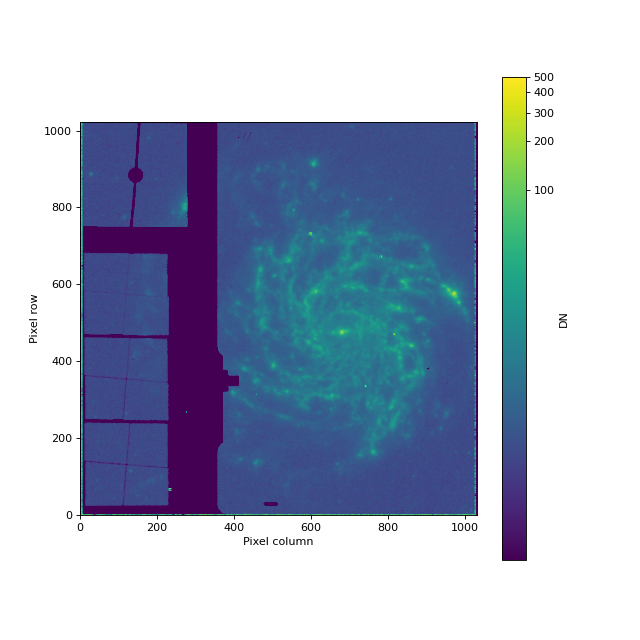

In [19]:
show_image(miri_cal.data, 2, 500)

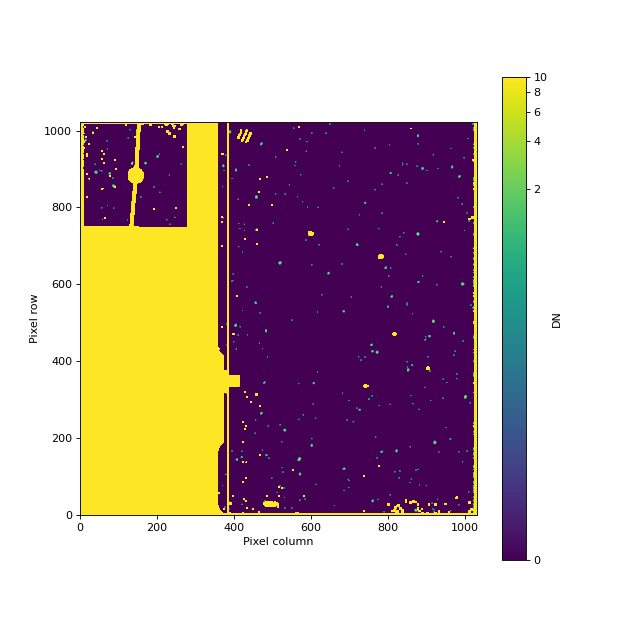

In [20]:
show_image(miri_cal.dq, 0, 10)

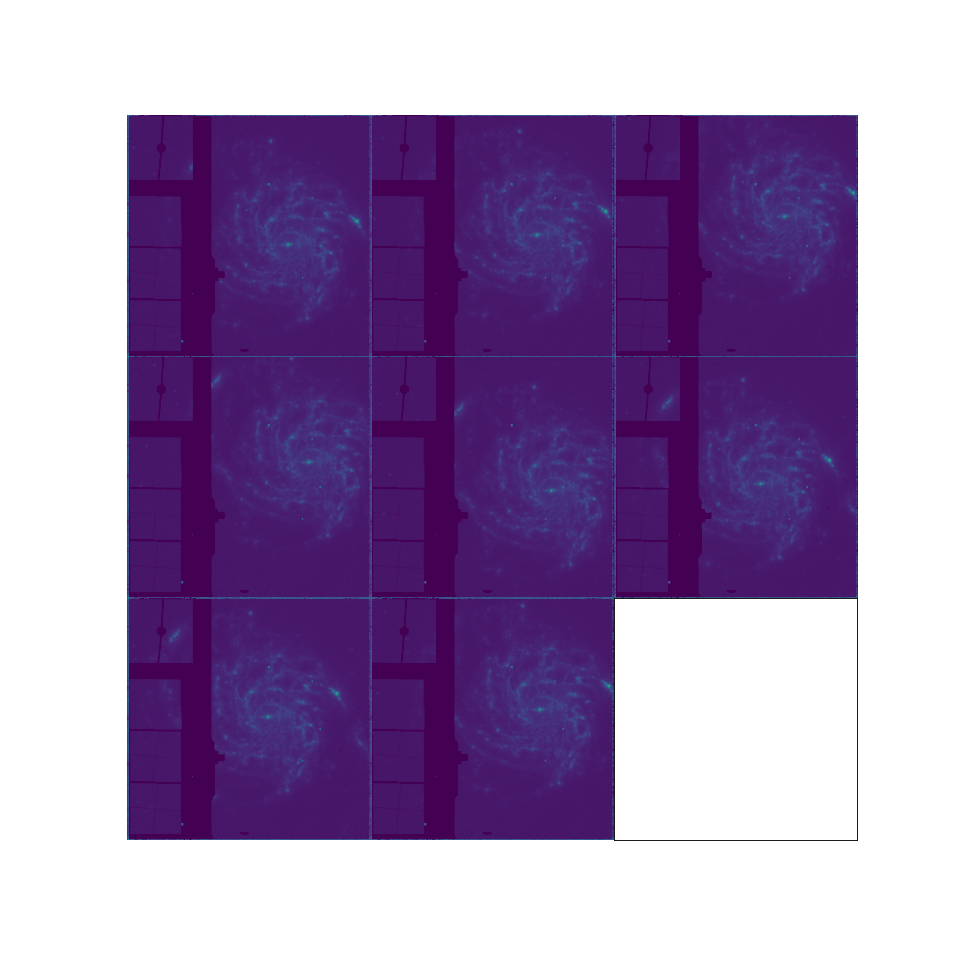

In [21]:
# display the images
fig = plt.figure(1, figsize=(12, 12))
ncols = len(miri_cal_files) // 3
grid = ImageGrid(fig, 111, nrows_ncols=(ncols+1, 3), axes_pad=0)

for i, cfile in enumerate(miri_cal_files):
    with datamodels.open(cfile) as miri_cal:
        cimage = miri_cal.data
        norm_data = simple_norm(cimage, "sqrt", min_cut=2, max_cut=500)
        grid[i].imshow(cimage, norm=norm_data, origin="lower")
        grid[i].axis('off')
        grid[i].set_xticks([])
        grid[i].set_yticks([])

## CALWEBB_IMAGE3

In [22]:
miri_cal_files = glob.glob(f"./stage2/*{filter}exp1_cal.fits")
output_dir = "./stage3/"
print(miri_cal_files)

miri_asn_name = f'miri_{filter}_stage3_asn'
miri_asn = asn_from_list.asn_from_list(miri_cal_files, rule=DMS_Level3_Base, product_name=miri_asn_name)

miri_asn_file = f'{miri_asn_name}.json'
with open(miri_asn_file, 'w') as outfile:
    name, serialized = miri_asn.dump(format='json')
    outfile.write(serialized)

['./stage2/det_image_seq1_MIRIMAGE_F770Wexp1_cal.fits', './stage2/det_image_seq2_MIRIMAGE_F770Wexp1_cal.fits', './stage2/det_image_seq3_MIRIMAGE_F770Wexp1_cal.fits', './stage2/det_image_seq4_MIRIMAGE_F770Wexp1_cal.fits', './stage2/det_image_seq5_MIRIMAGE_F770Wexp1_cal.fits', './stage2/det_image_seq6_MIRIMAGE_F770Wexp1_cal.fits', './stage2/det_image_seq7_MIRIMAGE_F770Wexp1_cal.fits', './stage2/det_image_seq8_MIRIMAGE_F770Wexp1_cal.fits']


In [23]:
# Using the run() method:

# Create an instance of the pipeline class
miri_im3 = calwebb_image3.Image3Pipeline()

# Set the output directory, and specify that you want
# to save the results
miri_im3.output_dir = output_dir
miri_im3.save_results = True

# Set some parameters for individual steps.
# HINT: the PSF FWHM for MIRI with the F700W filter
# is 2.187 pixels.
miri_im3.tweakreg.snr_threshold = 25.0  # 5.0 is the default
miri_im3.tweakreg.kernel_fwhm = 2.187  # 2.5 is the default
miri_im3.tweakreg.brightest = 10  # 100 is the default
miri_im3.source_catalog.kernel_fwhm = 2.187  # pixels
miri_im3.source_catalog.snr_threshold = 10.

# Call the run() method
miri_im3.run(miri_asn_file)

2022-03-10 15:31:10,731 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.
2022-03-10 15:31:10,736 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2022-03-10 15:31:10,742 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.
2022-03-10 15:31:10,748 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.
2022-03-10 15:31:10,753 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2022-03-10 15:31:10,758 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.
2022-03-10 15:31:10,763 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.
2022-03-10 15:31:10,941 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('miri_F770W_stage3_asn.json',).
2022-03-10 15:31:10,960 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '

2022-03-10 15:31:23,094 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'det_image_seq5_MIRIMAGE_F770Wexp1_cal':
2022-03-10 15:31:23,096 - stpipe.Image3Pipeline.tweakreg - INFO -      det_image_seq5_MIRIMAGE_F770Wexp1_cal
2022-03-10 15:31:23,166 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'det_image_seq6_MIRIMAGE_F770Wexp1_cal':
2022-03-10 15:31:23,168 - stpipe.Image3Pipeline.tweakreg - INFO -      det_image_seq6_MIRIMAGE_F770Wexp1_cal
2022-03-10 15:31:23,238 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'det_image_seq7_MIRIMAGE_F770Wexp1_cal':
2022-03-10 15:31:23,240 - stpipe.Image3Pipeline.tweakreg - INFO -      det_image_seq7_MIRIMAGE_F770Wexp1_cal
2022-03-10 15:31:23,306 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'det_image_seq8_MIRIMAGE_F770Wexp1_cal':
2022-03-10 15:31:23,307 - stpipe.Image3Pipeline.tweakreg - INFO -      det_image_seq8_MIRIMAGE_F770Wexp1_cal
2022-03-10 15:31:23,309 - stpipe.Image3Pipeline.tweakreg - INFO 

2022-03-10 15:31:25,906 - stpipe.Image3Pipeline.tweakreg - INFO -  
2022-03-10 15:31:26,100 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg done
2022-03-10 15:31:26,303 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch running with args (<ModelContainer>,).
2022-03-10 15:31:26,309 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'skymethod': 'match', 'match_down': True, 'subtract': False, 'stepsize': None, 'skystat': 'mode', 'dqbits': '0', 'lower': None, 'upper': None, 'nclip': 5, 'lsigma': 4.0, 'usigma': 4.0, 'binwidth': 0.1}
2022-03-10 15:31:26,434 - stpipe.Image3Pipeline.skymatch - INFO -  
2022-03-10 15:31:26,436 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() started

2022-03-10 15:32:28,433 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in ./stage3/det_image_seq3_MIRIMAGE_F770Wexp1_a3001_crf.fits
2022-03-10 15:32:28,946 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in ./stage3/det_image_seq4_MIRIMAGE_F770Wexp1_a3001_crf.fits
2022-03-10 15:32:29,446 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in ./stage3/det_image_seq5_MIRIMAGE_F770Wexp1_a3001_crf.fits
2022-03-10 15:32:29,951 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in ./stage3/det_image_seq6_MIRIMAGE_F770Wexp1_a3001_crf.fits
2022-03-10 15:32:30,732 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in ./stage3/det_image_seq7_MIRIMAGE_F770Wexp1_a3001_crf.fits
2022-03-10 15:32:31,239 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in ./stage3/det_image_seq8_MIRIMAGE_F770Wexp1_a3001_crf.fits
2022-03-10 15:32:31,241 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-03-1

2022-03-10 15:33:25,003 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline done


In [24]:
# Look at the resulting mosaic image
miri_mosaic_file = output_dir + miri_asn_name + '_i2d.fits'
miri_catalog_file = output_dir + miri_asn_name + '_cat.ecsv'

In [25]:
# Open the mosaic image
miri_mosaic = datamodels.open(miri_mosaic_file)

In [26]:
# Read in the source catalog
miri_source_cat = ascii.read(miri_catalog_file)

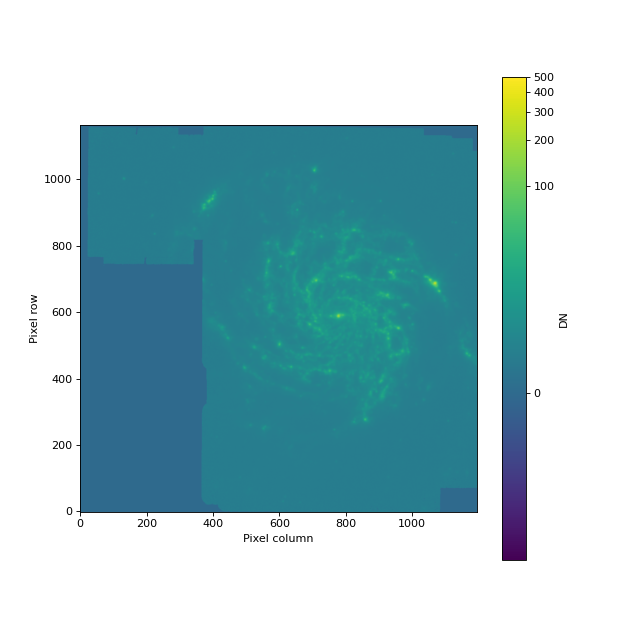

In [27]:
# Look at the mosaic
show_image(miri_mosaic.data, vmin=-5, vmax=500)

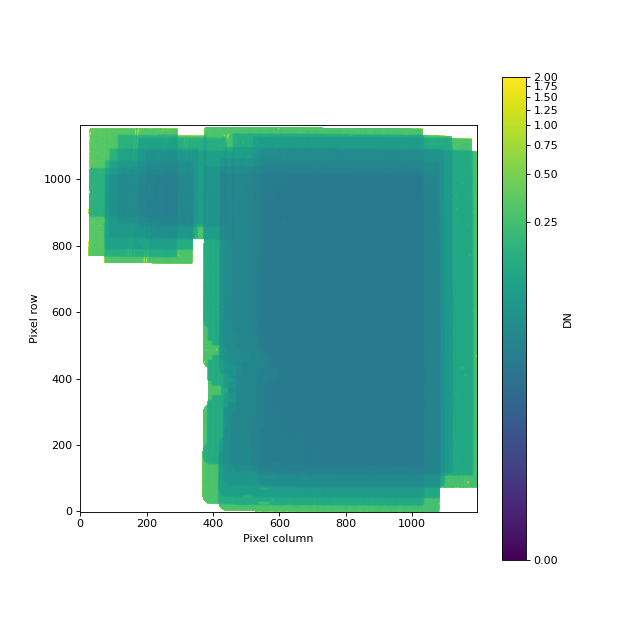

In [28]:
# Look at the mosaic data read noise uncertainties (i.e., coverage map)
show_image(miri_mosaic.var_rnoise, vmin=0.0, vmax=2)

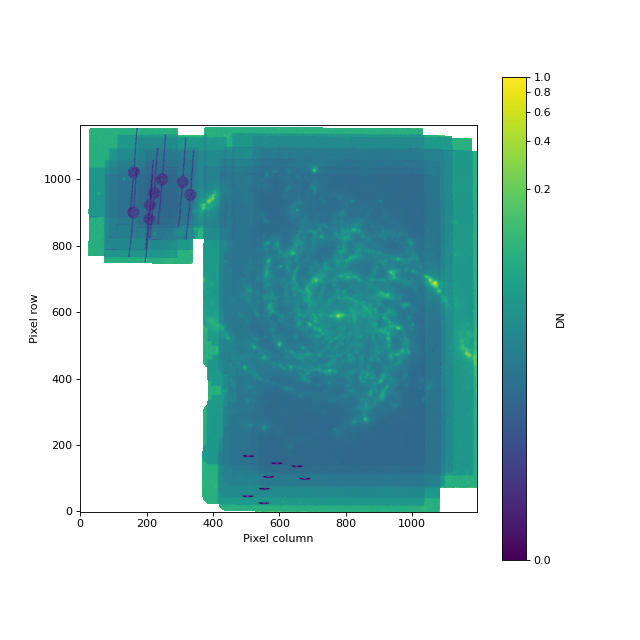

In [29]:
# Look at the mosaic data poisson uncertainties
show_image(miri_mosaic.var_poisson, vmin=0, vmax=1)

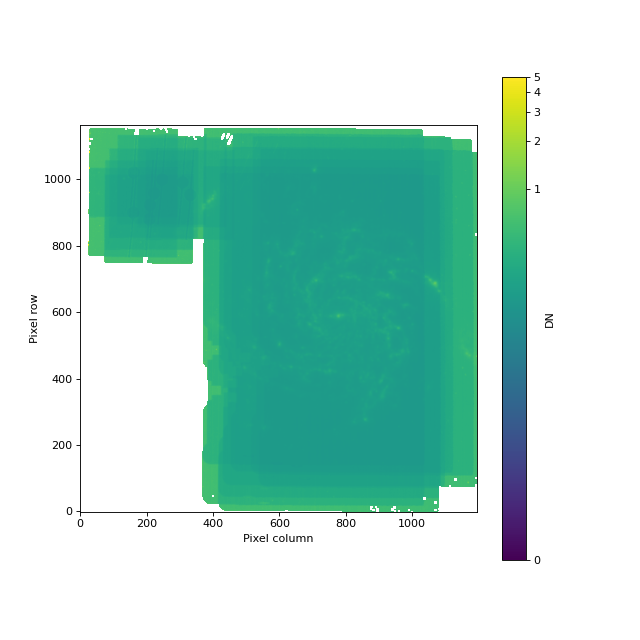

In [30]:
# Look at the mosaic total data uncertainties
show_image(miri_mosaic.err, vmin=0, vmax=5)

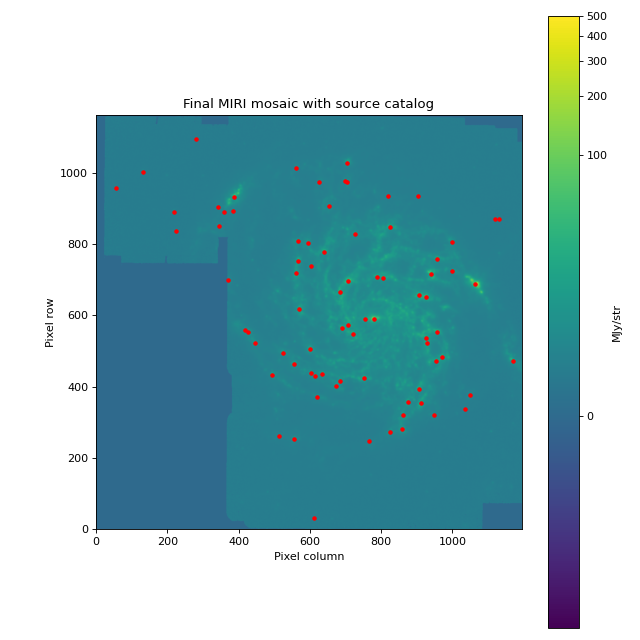

In [31]:
# Show the catalog sources on the mosaic
overlay_catalog(miri_mosaic.data, miri_source_cat, flux_limit=5e-7, vmin=-5, vmax=500,
                title='Final MIRI mosaic with source catalog')